# Pertussis
1. [Manual](#Manual)
1. [MCMC](#MCMC)
    1. [MCMC Model](#Model)
    1. [MCMC Results](#Results)

In [30]:
a = np.arange(0,5.9,1)
b = np.ones(6)
mu = 0.2
print (mu)
mu2 = np.ones(3) * 0.5 * mu
print (mu2)
mu2[-1] +=  3*0.5*mu
print(mu2)
a -= b*mu2
a

0.2
[ 0.1  0.1  0.1]
[ 0.1  0.1  0.4]


ValueError: operands could not be broadcast together with shapes (6,) (3,) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from scipy.integrate import odeint
%matplotlib inline

from time import clock, sleep
from datetime import datetime as dt
from pprint import pprint

from imp import reload
from pertussis import *

In [2]:
# # Initial Parameters
r_start = 1948
r_end = 2015
step = 1 / N
t_end = expand_time(r_end, start=r_start, step=step)
t_start = expand_time(r_start, start = r_start, step=step)

t_range = np.arange(t_start, t_end, 1)

# Manual
[==================================](#Charting)

|age|pop|ratio
|---|---|---|
|0|21.894|0.003854352
|1\6|21.894|0.003854352
|2\6|21.894|0.003854352
|0.5|65.682|0.011563056
|1|671.0796237|0.118140906
|7|634.652376|0.111728033
|13|703.6386403|0.123872792
|20|478.93896|0.084315304
|25|1491.8239|0.26262968
|45|995.11606|0.175186235
|65+|573.718908|0.101000938

In [4]:
# Find '98 distribution

ax = a_u - a_l

t_range
t_end

24455.0

In [6]:
# Show mean values fit
death = 65
state_0 = collect_state0(S0=0.8, Is0=1e-3, death=100)
state_0 = pack_flat(state_0)
cut98 = expand_time(1998, r_start)


# d = 1.0 ** np.arange(0, 300, 1) * N / death
d = get_delta()

# Run ODEs
RES = odeint(hetro_model, state_0, t_range,
             args=(4, 2, np.ones(11)*0.3, 1, d ))

# Prepare results
x = reduce_time(t_range, start=1948, step=step)
y = unpack(RES.T, *unpack_values)
ys = sum([a for a in y]).T
model98 = ys[cut98]
h = sum([i for i in y[:3]])
all_compartments = sum([i for i in y])
y.append(h)
y.append(all_compartments)
print (ys[0])
print (ys[cut98])

[ 0.00166667  0.00166667  0.00166667  0.005       0.06        0.06        0.07
  0.05        0.2         0.2         0.35      ]
1.0

[ 0.00166667  0.00166667  0.00166667  0.005       0.06        0.06        0.07
  0.05        0.2         0.2         0.35      ]
[ 0.003504    0.00349165  0.0034792   0.01031778  0.112546    0.10416451
  0.10971934  0.07183953  0.18919271  0.12029575  0.27144954]


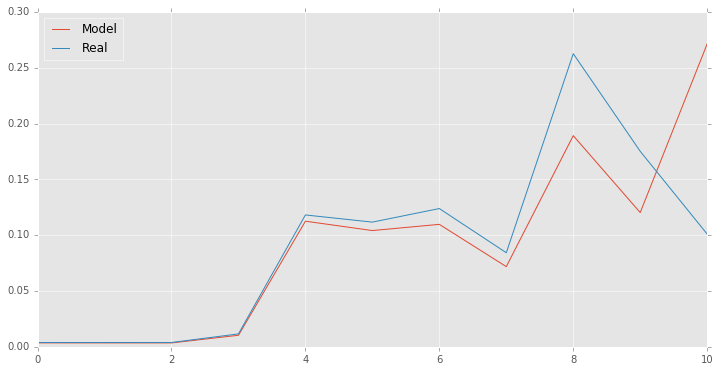

1.0


In [5]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(model98[:], label='Model')
ax.plot(dist98, label='Real')
plt.legend(loc='best')
plt.show()
print (model98.sum())

(73730, 11)


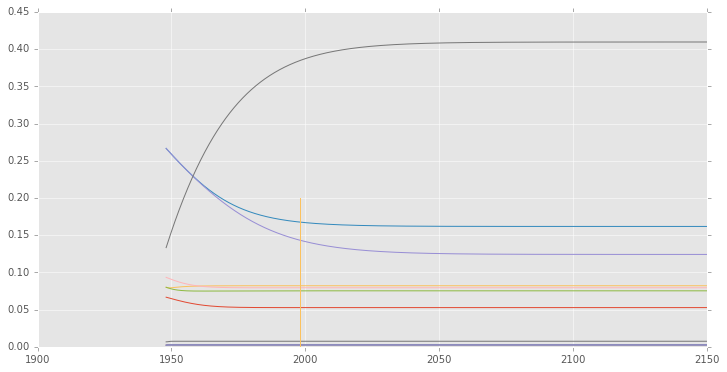

In [221]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x,ys[:,:], [1998,1998],[0,0.2])
print (ys.shape)
plt.show()

(73730, 11)


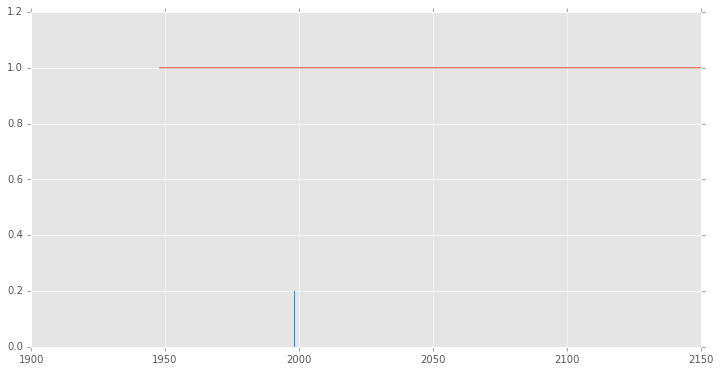

In [223]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x,ys.sum(axis=1), [1998,1998],[0,0.2])
print (ys.shape)
plt.show()

In [46]:
report_rate = np.ones(J)

array([ 1948.        ,  1948.00273973,  1948.00547945, ...,  2014.99178082,
        2014.99452055,  2014.99726027])

# MCMC
## Initial Parameters

## Data Loading

192 Monthly data values


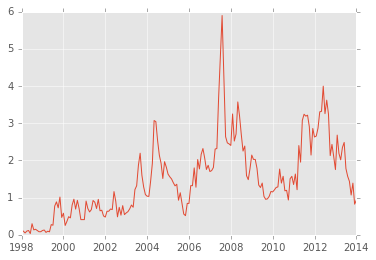

In [19]:
data, months = cases_monthly()
plt.plot(months,data)

In [233]:
# # Data
# data = np.genfromtxt('./data/yearly.csv', delimiter=',', skip_header=1)[:, 1]

# years = np.genfromtxt('./data/yearly.csv', delimiter=',', skip_header=1)[:, 0]
data_years, years = cases_yearly()
data_years /= 1e5

data_months, months = cases_monthly()
data_months /= 1e5

63 Yearly data values
192 Monthly data values


In [ ]:
#######################
###### Run Model ######
#######################
# i0 = pm.Uniform("Is0", 0, 0.1)
# s0 = pm.Uniform("S0", 0.1, 1 - i0)


# # State 0
# @pm.deterministic
# def state_0(S=s0, I=i0):
#     state_0 = collect_state0(S, I)
#     # state_0 = pack_flat(state_0)
#     return state_0

## Model

In [246]:
state_0 = collect_state0()
state_0 = pack_flat(state_0)

# Priors
o = pm.Uniform('omega', 3, 6)
p = pm.Uniform('phi', 0, o + 0.1)
f1 = pm.Uniform('f1', 0, 0.5)
f2 = pm.Uniform('f2', 0, 0.5)
f3 = pm.Uniform('f3', 0, 0.5)
z = pm.Uniform('zeta', 0, 4)

@pm.deterministic
def f(f1=f1, f2=f2, f3=f3):
    s1, s2 = 5, 4
    s3 = J - s1 - s2
    return np.concatenate((f1 * np.ones(s1),
                           f2 * np.ones(s2),
                           f3 * np.ones(s3)))

[ 0.00222222  0.00222222  0.00222222  0.00666667  0.08        0.08
  0.09333333  0.06666667  0.26666667  0.26666667  0.13333333]
1.0



In [247]:
@pm.deterministic
def sim(o=o, p=p, f=f, z=z):
    # print('A ', end="")
    clk = clock()
    res = odeint(hetro_model, pack_flat(state_0), t_range,
                 args=(o, p, f, z,d ))

    # print (RES.shape)
    # print(RES.sum(axis=1))
    res = unpack(res.T, *unpack_values)
    # print (RES[3].shape)
    # res = reduce_year(RES[3].sum(axis=0))[1951 - t_start:2014 - t_start]
    # print (res.shape)
    # print(clock() - clk)
    return res

In [250]:
@pm.deterministic
def mu1(sim=sim):
    res = reduce_year(sim[3].sum(axis=0))[1951 - t_start:2014 - t_start]
    return res

# @pm.deterministic
# def mu2(sim=sim):
#     res = reduce_month(sim)
#     return res

# TODO: Two sigmas
sigma1 = pm.Uniform('sigma1', 0, 0.5)

c:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [249]:
# sigma2 = pm.Uniform('sigma2', 0, sigma1/12)
Y1 = pm.Normal('Y1', mu=mu1, tau=1 / sigma1 ** 2, observed=True, value=data_years)
# Y2 = pm.Normal('Y2', mu=mu2, tau=1 / sigma2 ** 2, observed=True, value=data_monthly)

# TODO: Set weights? Is it possible?

# model = pm.Model([Y1, o, p, sim, f, f1, f2, f3, mu1, sigma1, s0, i0, state_0, z])
model = pm.Model([Y1, o, p, sim, f, f1, f2, f3, mu1, sigma1, z])

error: (nmu==1||nmu==n) failed for hidden nmu: normal:nmu=0

In [63]:
# TODO: Other Backend
mcmc = pm.MCMC(model, db="ram")
mcmc.sample(iter=20, burn=0)  #######################################################################################

 [-----            15%                  ] 3 of 20 complete in 23.8 secHalting at iteration  2  of  20


# Results
## Prepare Results and run model with parameters

In [ ]:
np.split()

In [121]:
def my_reduce(vec):
    np.split(vec, months)
months = (31, 28, 31, 30,
              31, 30, 31, 31,
              30, 31, 30, 31)
# z = y[3].sum(axis=0)
z = np.ones(365*3)
a = z.reshape(3, 365)
b = a[0]
m = np.cumsum(months)
m
np.split(a,m)
np.apply_along_axis(my_reduce,a,m)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [64]:
# m_s = mcmc.trace('S0')[t_tally:].mean()
# m_i = mcmc.trace('Is0')[t_tally:].mean()
t_tally = 0
m_f = mcmc.trace('f')[t_tally:].mean()
m_o = mcmc.trace('omega')[t_tally:].mean()
m_p = mcmc.trace('phi')[t_tally:].mean()
m_z = mcmc.trace('zeta')[t_tally:].mean()

# Show mean values fit
state_0 = collect_state0()
state_0 = pack_flat(state_0)


RES = odeint(hetro_model, state_0, t_range,
             args=(m_o, m_p, m_f, m_z))
# # Results
x = reduce_time(t_range, start=t_start, step=step)
y = unpack(RES.T, *unpack_values)
h = sum([i for i in y[:3]])
all_compartments = sum([i for i in y])
y.append(h)
y.append(all_compartments)

## Charting
[========================](#Manual)

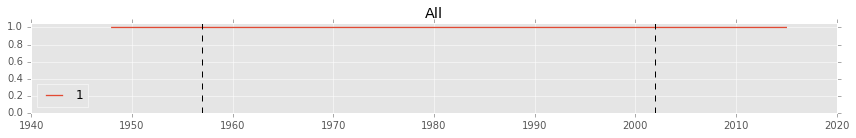

In [253]:
fig, ax = draw_model(x, y[-1:], ["All"], collapse=True)
fig.set_size_inches(12,2)
plt.tight_layout()
z = y[-1:][0]
plt.show()

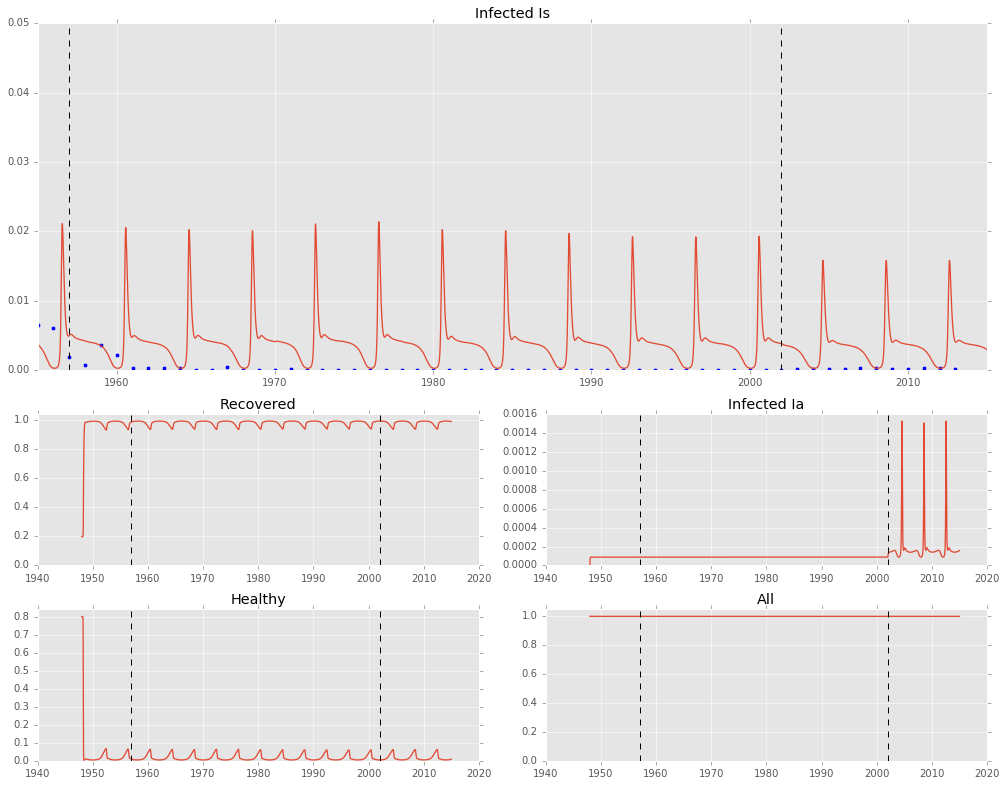

In [264]:
fig, ax = draw_model(x, y[3:], ["Infected Is", "Infected Ia", "Recovered", "Healthy", "All"], split=0, collapse=True)
plt.tight_layout()
ax[0].scatter(years, data_years)
ax[0].set_xlim(1955, 2015)
ax[0].set_ylim(0, 0.05)
plt.show()

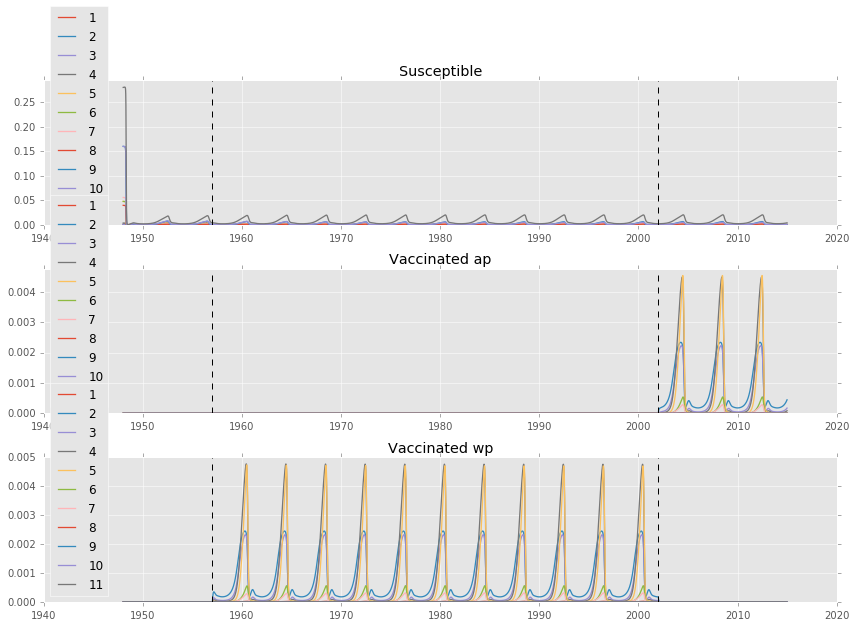

In [255]:
fig2, ax2 = draw_model(x, y[0:3], ["Susceptible", "Vaccinated ap", "Vaccinated wp"], split=False, collapse=False)
plt.tight_layout()
plt.show()

In [256]:

fig4, ax4 = plot_stoch_vars(mcmc)
fig4.savefig('./img/mcmc{}.png'.format(dt.utcnow()).replace(':', '-'))
for ax in ax3:
    ax.set_xlim(1955, 2013)
ax3[0].set_ylim(0, 0.05)

plt.tight_layout()
plt.show()

NameError: name 'mcmc' is not defined

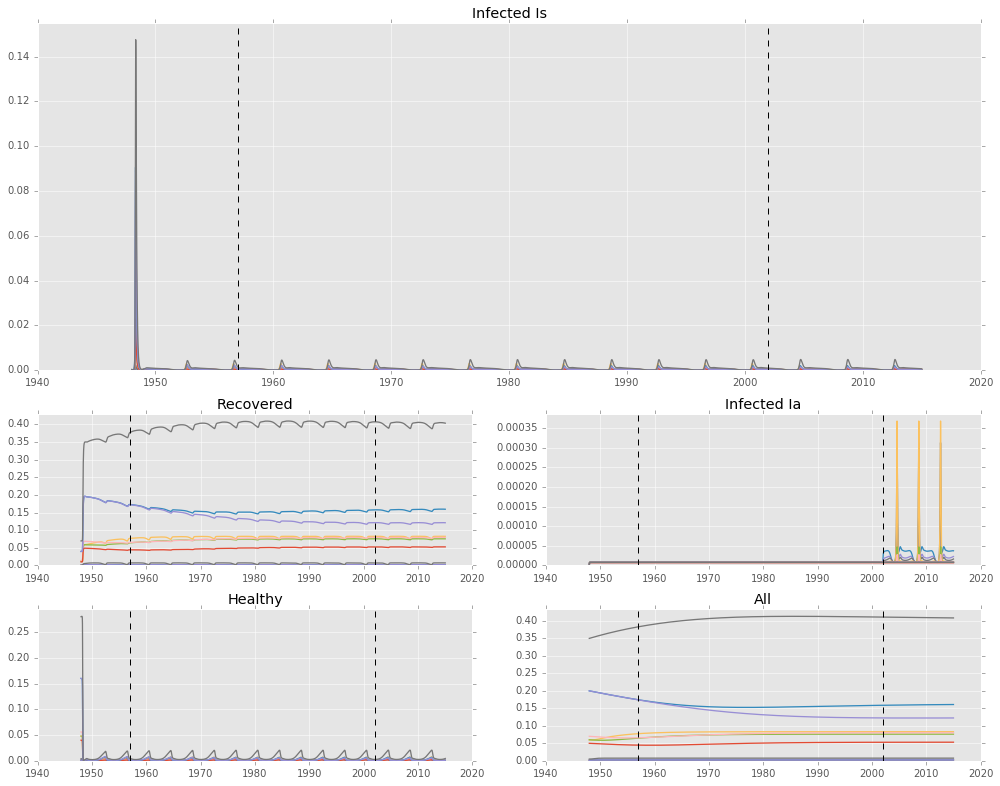

In [257]:
fig, ax = draw_model(x, y[3:], ["Infected Is", "Infected Ia", "Recovered", "Healthy", "All"], split=0, collapse=False)

plt.tight_layout()
plt.show()